# Machine Learning Modeling

---

## Import packages & Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import joblib

# shows plots in jupyter notebook
%matplotlib inline

# set plot style
sns.set(color_codes=True)

In [2]:
clients_df = pd.read_csv('../data/processed/processed_data.csv')
print('Shape of the dataset: ', clients_df.shape)
clients_df.head()

Shape of the dataset:  (14606, 18)


,cons_12m,cons_gas_12m,off_peak_forecast_energy,off_peak_forecast_power,imp_cons,margin_net_pow_ele,net_margin,pow_max,churn,off_peak_mean_energy,off_peak_mean_power,off_peak_diff_energy,off_peak_diff_power,origin,channel,discount_energy,active_products,antiquity
0,0,54946,0.114481,40.606701,0.00,25.44,678.99,43.648,1,0.124787,40.942265,0.020057,3.700961,lxidpiddsbxsbosboudacockeimpuepw,foosdfpfkusacimwkcsosbicdxkicaua,NO_DISCOUNT,MULTIPLE,RECENT
1,4660,0,0.145711,44.311378,0.00,16.38,18.89,13.800,0,0.149609,44.311375,-0.003767,0.177779,kamkkxfxxuwbdslkwifmmcsiusiuosws,MISSING,NO_DISCOUNT,ONE,OLD
2,544,0,0.165794,44.311378,0.00,28.60,6.60,13.856,0,0.170512,44.385450,-0.004670,0.177779,kamkkxfxxuwbdslkwifmmcsiusiuosws,foosdfpfkusacimwkcsosbicdxkicaua,NO_DISCOUNT,ONE,OLD
3,1584,0,0.146694,44.311378,0.00,30.22,25.46,13.200,0,0.151210,44.400265,-0.004547,0.177779,kamkkxfxxuwbdslkwifmmcsiusiuosws,lmkebamcaaclubfxadlmueccxoimlema,NO_DISCOUNT,ONE,OLD
4,4425,0,0.116900,40.606701,52.32,44.91,47.98,19.800,0,0.124174,40.688156,-0.006192,0.162916,kamkkxfxxuwbdslkwifmmcsiusiuosws,MISSING,NO_DISCOUNT,ONE,OLD


---

## Data Preprocessing

In [3]:
def split_data(X, y):
    """
    Split the data into train and test sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [4]:
X = clients_df.drop('churn', axis=1)
y = clients_df['churn']

# apply log transformation
X[['cons_12m', 'cons_gas_12m', 'imp_cons', 'pow_max']] = np.log(X[['cons_12m', 'cons_gas_12m', 'imp_cons', 'pow_max']] + 1)

# split data into train and test sets
X_train, X_test, y_train, y_test = split_data(X, y)
print('Shape of the train set: ', X_train.shape, y_train.shape)
print('Shape of the test set: ', X_test.shape, y_test.shape)

Shape of the train set:  (11684, 17) (11684,)
Shape of the test set:  (2922, 17) (2922,)


In [5]:
X.dtypes

cons_12m                    float64
cons_gas_12m                float64
off_peak_forecast_energy    float64
off_peak_forecast_power     float64
imp_cons                    float64
margin_net_pow_ele          float64
net_margin                  float64
pow_max                     float64
off_peak_mean_energy        float64
off_peak_mean_power         float64
off_peak_diff_energy        float64
off_peak_diff_power         float64
origin                       object
channel                      object
discount_energy              object
active_products              object
antiquity                    object
dtype: object

In [6]:
# create a preprocessor for categorical and numerical features: OHE and Standardization
categories = X.select_dtypes(include=['object']).columns.tolist()
numerical = X.select_dtypes(include=['float64']).columns.tolist()

one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
standard_scaler = StandardScaler()

---

## Baseline Model

First, let's establish a baseline.
Since the churn rate is about 10%, we might think of random guessing, that predicts churn with a probability of 10%. We might also think of a model that always predicts non churn, which would be right 90% of the time.

Let's define a metric to evaluate our models.  
When we go back to the business problem, we don't want to lose customers, in other words, when there is a company that is likely to churn, we want to be able to identify it.  Recall is the metric that measures that.
One other thing is that when we predict that a company will churn, we want to be right, because we'll be giving it a discount of 20%, which is a cost for us. Precision is the metric that measures that.

Given that, we'll use the F1 score, which is the harmonic mean of precision and recall.

In [7]:
def print_scores(y_true, y_pred):
    print(f'Accuacy: {accuracy_score(y_true, y_pred):.2f}')
    print(f'Precision: {precision_score(y_true, y_pred, zero_division=0):.2f}')
    print(f'Recall: {recall_score(y_true, y_pred, zero_division=0):.2f}')
    print(f'F1: {f1_score(y_true, y_pred, zero_division=0):.2f}')

In [8]:
# first baseline
baseline_1_guesses = np.random.choice([0, 1], size=len(clients_df), p=[.9, .1])
print_scores(clients_df.churn, baseline_1_guesses)

Accuacy: 0.83
Precision: 0.09
Recall: 0.09
F1: 0.09


## Logistic Regression

We see that the baseline model has an F1 score of around 10%, with both precision and recall being equal.  
We need to achieve better results with out modeling.  
Since Logistic Regression is a simple model, let's see if it performs better than this simple baseline, if it does, let it be our actual baseline.

In [9]:
def try_model(model):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print('Train scores:')
    print_scores(y_train, y_train_pred)
    print('\n')
    print('Test scores:')
    print_scores(y_test, y_test_pred)

In [10]:
lreg = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('one_hot_encoder', one_hot_encoder, categories),
        ('standard_scaler', standard_scaler, numerical)
    ])),
    ('classifier', LogisticRegression(random_state=42, max_iter=500))
])

try_model(lreg)

Train scores:
Accuacy: 0.90
Precision: 0.36
Recall: 0.01
F1: 0.01


Test scores:
Accuacy: 0.90
Precision: 0.00
Recall: 0.00
F1: 0.00


The model is performing worst than the baseline on data it was trained on. 1% recall is the worst possible result. This may be due to the fact that data is not linearly separable, and no linear model can perform well on it.

## Decision Tree

Since the data is not linearly separable, let's try a non linear model, the Decision Tree.

In [11]:
dt = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('one_hot_encoder', one_hot_encoder, categories),
    ], remainder='passthrough')),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

try_model(dt)

Train scores:
Accuacy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00


Test scores:
Accuacy: 0.84
Precision: 0.22
Recall: 0.26
F1: 0.24


We see that our assumption was right, and our data is not linearly separable.  
Seems that our decision tree classifier did well overfitting the train data, with a performance on the test data that is a lot better than the baseline.  
Let's work on improving this model by chosing the right hyperparameters.

Before doing that, we would like to see feature importances.

In [12]:
def plot_feature_importances(importances, columns):
    '''Function to be used for plotting feature importances for the tree-based models'''
    # sort indices in descending order of feature importances
    indices = np.argsort(importances)[::-1]
    importances = importances[indices]
    columns = columns[indices]
    # plot
    plt.figure(figsize=(8, 8))
    sns.barplot(x=importances, y=columns)
    plt.show()

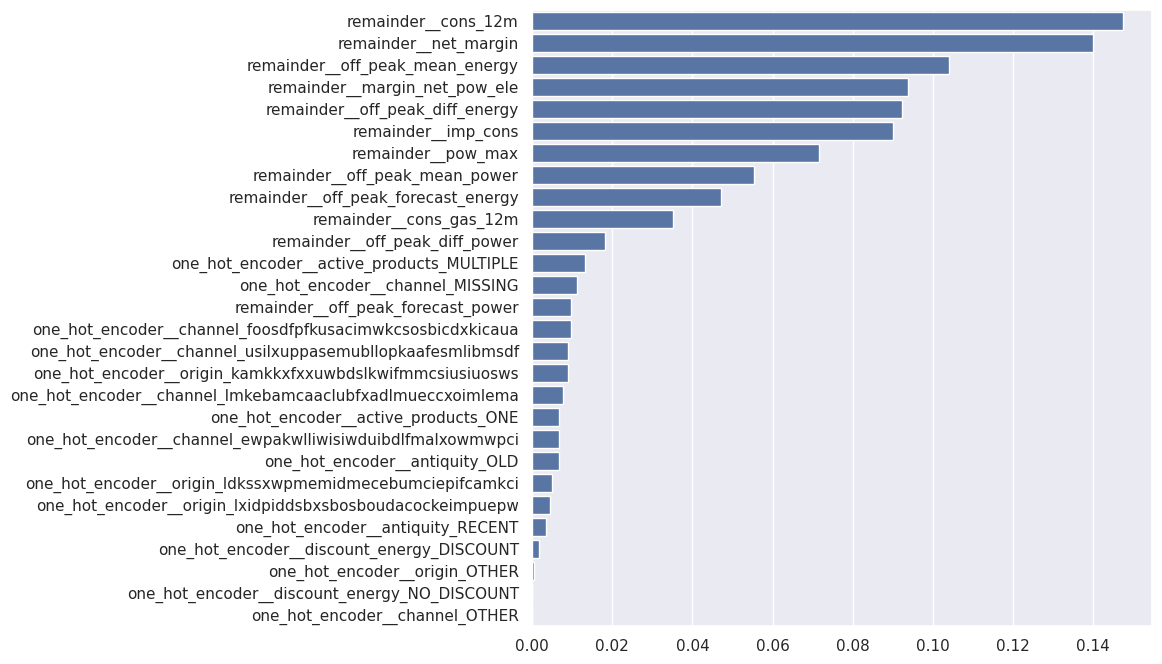

In [13]:
plot_feature_importances(dt.named_steps['classifier'].feature_importances_, dt.named_steps['preprocessor'].get_feature_names_out())

Notice that the most important features are those related to consumption, price and revenue. Categorical features, except the channel, had no effect on the churn.

In [14]:
X.drop(['origin', 'channel', 'discount_energy', 'active_products', 'antiquity'], axis=1, inplace=True)

In [15]:
X_train, X_test, y_train, y_test = split_data(X, y)

In [16]:
dt = DecisionTreeClassifier(random_state=42)
try_model(dt)

Train scores:
Accuacy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00


Test scores:
Accuacy: 0.84
Precision: 0.22
Recall: 0.25
F1: 0.23


Removing the categorical features was a good idea, we see that our model overfits the same as before, and the performance on the test set didn't change.

Let's start tuning the hyperparameters.

In [17]:
# define the parameter grid
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 7],
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 5}, {0: 1, 1: 7}]
}

# create classifier
dt = DecisionTreeClassifier(random_state=42)

# create GridSearchCV object
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='recall')

# fit object to the data
grid_search.fit(X_train, y_train)

# print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'class_weight': {0: 1, 1: 7}, 'max_depth': 10, 'min_samples_split': 7}
Best Score:  0.35594713656387666


In [18]:
dt = grid_search.best_estimator_

try_model(dt)

Train scores:
Accuacy: 0.79
Precision: 0.26
Recall: 0.64
F1: 0.37


Test scores:
Accuacy: 0.74
Precision: 0.17
Recall: 0.42
F1: 0.24


We have successfully reduced the effect of overfitting to some extent. In order to have a more balanced model (in terms of recall and precision), let's try to work on the probability threshold.

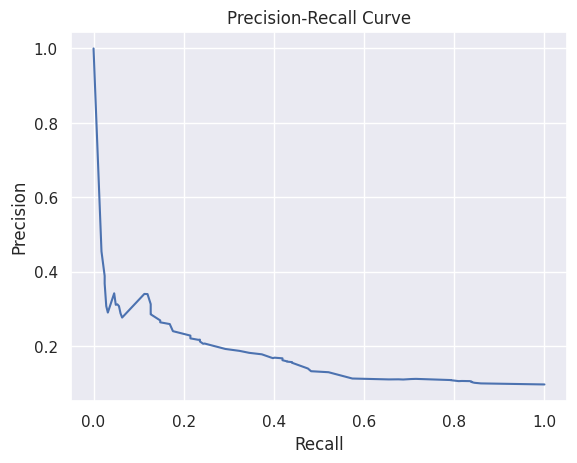

In [19]:
# predict probabilities for the positive class
y_scores = dt.predict_proba(X_test)[:, 1]

# calculate precision and recall values
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [20]:
# apply threshold
y_pred = (y_scores >= 0.62).astype(int)

# print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      2638
           1       0.21      0.24      0.22       284

    accuracy                           0.84      2922
   macro avg       0.56      0.57      0.57      2922
weighted avg       0.85      0.84      0.84      2922



We've reached the final version of the decision tree model, with an F1 score of 0.22, split between 24% recall and 21% precision.  
These results are indeed useful, eventhough we have a hard time reducing overfitting for this model. That's why we'll move to a more complex model, the Random Forest.

## Random Forest

The problem with decision trees is that they tend to overfit the data severely. Even after picking more suitable hyperparameters, we need to look for more ways to improve the model.  
Random forest is going to allow us to do that, by combining the power of decision trees in catching non linear relationships, and more choices and options to reduce overfitting through the ensemble strategy.  
Random forest is also a model that could be interpreted, providing with feature importances, and the ability to play with the probability threshold for classification.

In [21]:
rf = RandomForestClassifier(random_state=42)

try_model(rf)

Train scores:
Accuacy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00


Test scores:
Accuacy: 0.91
Precision: 0.77
Recall: 0.08
F1: 0.15


We see that, just like the decision tree, the random forest model is overfitting the training data, which is good because we know that it has learned something unlike the logistic regression model.  
We worked with the same features we used with the last version of the decision tree model (dropping categories and keeping consumption, price and revenue features, which we used without any preprocessing because the different scales don't affect rules based models).

In [22]:
# define the parameter grid
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 7],
    'max_features': ['sqrt', None],
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 5}, {0: 1, 1: 7}]
}

# create classifier
rf = RandomForestClassifier(random_state=42)

# create GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='recall', n_jobs=-1)

# fit object to the data
grid_search.fit(X_train, y_train)

# print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'class_weight': {0: 1, 1: 7}, 'max_depth': 5, 'max_features': None, 'min_samples_split': 2}
Best Score:  0.3709251101321586


In [23]:
rf = grid_search.best_estimator_

try_model(rf)

Train scores:
Accuacy: 0.78
Precision: 0.21
Recall: 0.47
F1: 0.29


Test scores:
Accuacy: 0.76
Precision: 0.17
Recall: 0.38
F1: 0.24


Notice how overfitting is reduced to such an extent where there is only a tiny difference between train and test set performances, meaning that this is a good version of the model we obtained.  
We can work our way up with the probability calibrating technique as well.

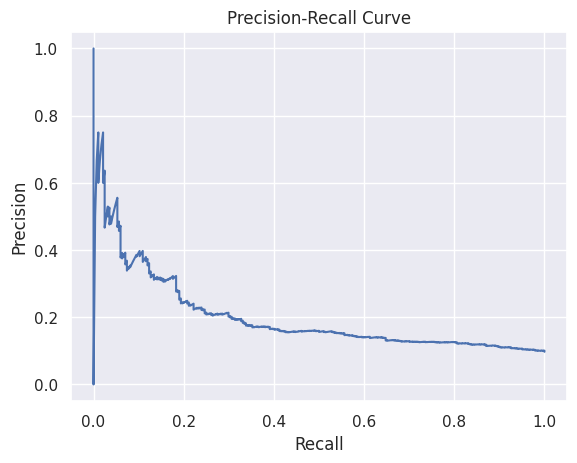

In [24]:
y_scores = rf.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [25]:
y_pred = (y_scores >= 0.53).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      2638
           1       0.20      0.31      0.24       284

    accuracy                           0.81      2922
   macro avg       0.56      0.59      0.57      2922
weighted avg       0.85      0.81      0.83      2922



Our metrics are also approving that it was worth trying out the random forest classification model, it has the same amount of precision (20%) as the decision tree, but a 31% recall (instead of 24%), and an overall 25% F1 score.

Let's look at the most important features that our final model uses for explaining and predicting churn.

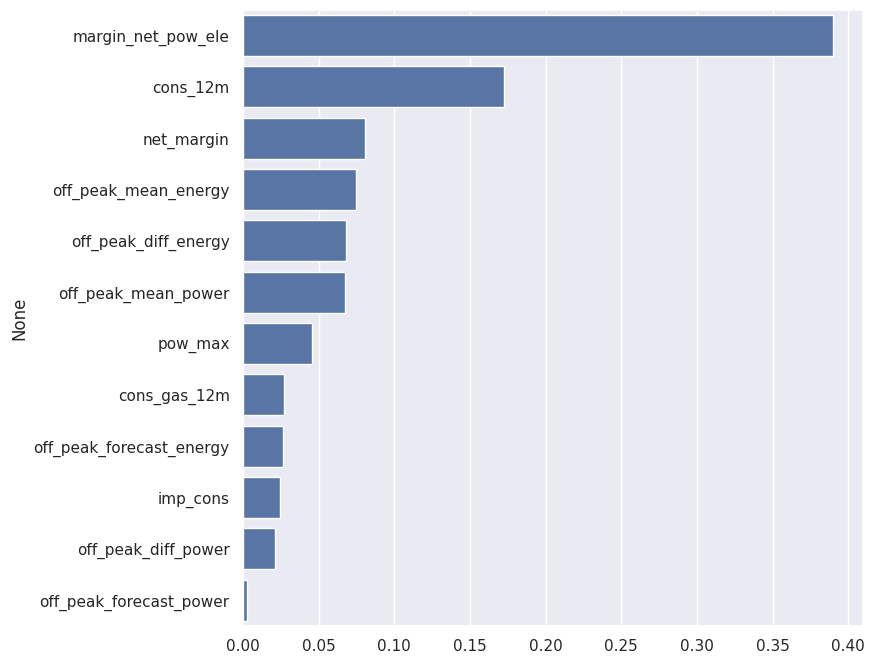

In [26]:
plot_feature_importances(rf.feature_importances_, X_train.columns)

We see that the most important features are the net margin of power consumption, last year's consumption, and the net margins of our clients. Then after these three, we find the features that are related to price changes and tendancy, meaning that the assumptions that the price is the main driver of churn is not entirely true, as we've just found features that are more important.

---

## Conslusion

To recap, we have been able to create a good and useful model, using the Random Forest Classifier with a suitable choice of hyperparameters, the model was fast to train, and faster in making predictions.

Despite all of what we were able to do so far, we cannot say that the performance is ideal because, first we still didn't try the model to see what impact is it going to have on the business, and second our data is incomplete, and in order to have a good model that captures the entire information on churn, we need more data, as price, consumption and revenue are not enough.

Let's save the final model, and the data used in training and testing.

In [27]:
joblib.dump(rf, '../models/random_forest.joblib')

['../models/random_forest.joblib']

In [31]:
X.to_csv('../data/processed/model_data.csv', index=False)